CPA.py file

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  4 02:08:22 2020

@author: stjepan
"""


import numpy as np

HW = [bin(n).count("1") for n in range(0,256)]

sbox=(
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16)

def intermediate(pt, keyguess):
    return sbox[pt ^ keyguess]

traces = np.load(r'.\chipwhisperer\traces.npy')
pt = np.load(r'.\chipwhisperer\plain.npy')
knownkey = np.load(r'.\chipwhisperer\key.npy')
numtraces = np.shape(traces)[0]-1
numpoint = np.shape(traces)[1]

#Use less than the maximum traces by setting numtraces to something
numtraces = 10000

traces = traces[0:numtraces,:]

#Set 16 to something lower (like 1) to only go through a single subkey
bestguess = [0]*16
ge = np.zeros(16)
for bnum in range(0, 1):
    cpaoutput = [0]*256
    maxcpa = [0]*256
    for kguess in range(0, 256):
        #print ("Subkey %2d, hyp = %02x: "%(bnum, kguess)),

        #Initialize arrays &amp; variables to zero
        sumnum = np.zeros(numpoint)
        sumden1 = np.zeros(numpoint)
        sumden2 = np.zeros(numpoint)

        hyp = np.zeros(numtraces)
        for tnum in range(0, numtraces):
            hyp[tnum] = HW[intermediate(pt[tnum][bnum], kguess)]


        #Mean of hypothesis
        meanh = np.mean(hyp, dtype=np.float64)

        #Mean of all points in trace
        meant = np.mean(traces, axis=0, dtype=np.float64)

        #For each trace, do the following
        for tnum in range(0, numtraces):
            hdiff = (hyp[tnum] - meanh)
            tdiff = traces[tnum,:] - meant

            sumnum = sumnum + (hdiff*tdiff)
            sumden1 = sumden1 + hdiff*hdiff 
            sumden2 = sumden2 + tdiff*tdiff

        cpaoutput[kguess] = sumnum / np.sqrt( sumden1 * sumden2 )
        maxcpa[kguess] = max(abs(cpaoutput[kguess]))

        #print (maxcpa[kguess])

    bestguess[bnum] = np.argmax(maxcpa)

    cparefs = np.argsort(maxcpa)[::-1]

    #Find GE
    ge[bnum] = list(cparefs).index(knownkey[0][bnum])

for b in range (0, 16): 
    print ("Best Key Guess: ",bestguess[b], " GE: ", ge[b])


<ipython-input-5-108981d4978b>:80: RuntimeWarning: invalid value encountered in true_divide
  cpaoutput[kguess] = sumnum / np.sqrt( sumden1 * sumden2 )


Best Key Guess:  43  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0
Best Key Guess:  0  GE:  0.0


Template attack

Pooled template needs more measurements to break.

[[ 0.05566406 -0.22167969 -0.09472656 ... -0.19238281 -0.07617188
  -0.07617188]
 [ 0.04882812 -0.23339844 -0.10546875 ... -0.22265625 -0.10253906
  -0.09667969]
 [ 0.05566406 -0.22070312 -0.09960938 ... -0.21386719 -0.09277344
  -0.09375   ]
 [ 0.05078125 -0.22558594 -0.10058594 ... -0.203125   -0.0859375
  -0.08398438]]


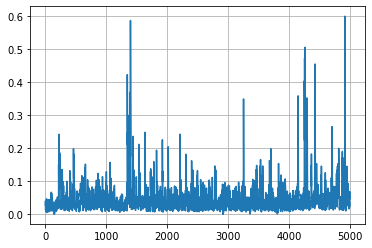

LinAlgError: singular matrix

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  4 02:08:22 2020

@author: stjepan
"""


import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

hamming = [bin(n).count("1") for n in range(256)]

sbox=(
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16) 

def cov(x, y):
    return np.cov(x, y)[0][1]

traces = np.load(r'.\chipwhisperer\traces.npy')
pt = np.load(r'.\chipwhisperer\plain.npy')
knownkey = np.load(r'.\chipwhisperer\key.npy')


tracesTrain = traces[0:2000]
ptTrain  = pt[0:2000]

tracesTest = traces[9990:10000]
ptTest  = pt[9990:10000]

outputSbox = [sbox[ptTrain[i][0] ^ knownkey[i][0]] for i in range(len(ptTrain))] 
outputSboxHW   = [hamming[s] for s in outputSbox]

TracesHW = [[] for _ in range(9)]

for i in range(len(tracesTrain)):
    HW = outputSboxHW[i]
    TracesHW[HW].append(tracesTrain[i])

TracesHW = [np.array(TracesHW[HW]) for HW in range(9)]

print(TracesHW[0])

Means = np.zeros((9, len(tracesTrain[0])))
for i in range(9):
    Means[i] = np.average(TracesHW[i], 0)
    
SumDiff = np.zeros(len(tracesTrain[0]))
for i in range(9):
    for j in range(i):
        SumDiff += np.abs(Means[i] - Means[j])

plt.plot(SumDiff)
plt.grid()
plt.show()

features = []
numFeatures = 50
featureSpacing = 5
# lower featurespacing means we get duplicate features possibly
for i in range(numFeatures):
    nextFeature = SumDiff.argmax()
    features.append(nextFeature)
    
    featureMin = max(0, nextFeature - featureSpacing)
    featureMax = min(nextFeature + featureSpacing, len(SumDiff))
    for j in range(featureMin, featureMax):
        SumDiff[j] = 0

meanMatrix = np.zeros((9, numFeatures))
covMatrix  = np.zeros((9, numFeatures, numFeatures))
for HW in range(9):
    for i in range(numFeatures):
        meanMatrix[HW][i] = Means[HW][features[i]]
        for j in range(numFeatures):
            x = TracesHW[HW][:,features[i]]
            y = TracesHW[HW][:,features[j]]
            covMatrix[HW,i,j] = cov(x, y)

key_rank = np.zeros(16)
pooledCov = np.average(covMatrix, 0)
P_k = np.zeros(256)
for j in range(len(tracesTest)):
    a = [tracesTest[j][features[i]] for i in range(len(features))]
    
    for kguess in range(0, 256):
        HW = hamming[sbox[ptTest[j][0] ^ kguess]]
        rv = multivariate_normal(meanMatrix[HW], covMatrix[HW])
        p_kj = rv.pdf(a)
        P_k[kguess] += np.log(p_kj)

    print (P_k.argsort()[-15:])    
    tarefs = np.argsort(P_k)[::-1]
    key_rank[0] = list(tarefs).index(knownkey[0][0])
    print(key_rank[0])

SVC(C=1, gamma=1, probability=True)
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.9141978327023671
[  6  71  37  69 167  42  97 107 103 101  34 175 165  11  43]
0
[ 15  58  11  37  14 111 180  97  71   7  47 167 165 175  43]
0
[165 103 167   1  11  42  71 175  97  37  34  33   7  47  43]
0
[ 31  75   2  11  33 103  15   9  37   7  42  34  40  47  43]
0
[ 35   9  27  15 103   7 107  26  37  11  40  47  42  34  43]
0
[118  75   9 107  17  37  35  19 127  40  11  47  42  34  43]
0
[ 19  38 107   9  15  75  35 118 127  11  47  40  42  34  43]
0
[  9  38   2  75 118  15  35 127 107  11  47  40  42  34  43]
0
[ 19   2 118  15  35  75 127 107  11   9  47  40  34  42  43]
0
[ 31   2  41  15 127  35 107  11  75   9  40  47  34  42  43]
0


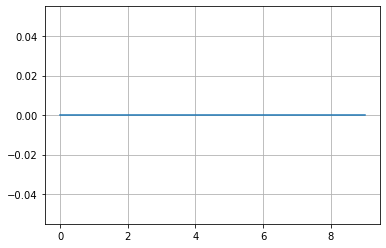

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  4 02:08:22 2020

@author: stjepan
"""


import numpy as np #required for general computations
from sklearn import preprocessing #for importing pre-processing techniques
from sklearn.feature_selection import chi2, SelectKBest #for feature selection
import matplotlib.pyplot as plt #for plotting the graphs
from sklearn.model_selection import GridSearchCV #for grid search and cross validation

#AES s-box
sbox=(
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16) 

#loading the traces, plaintext, and key from npy
traces = np.load(r'.\chipwhisperer\traces.npy')
pt = np.load(r'.\chipwhisperer\plain.npy')
knownkey = np.load(r'.\chipwhisperer\key.npy')

#we take first 10000 traces as 10001 is empty (thus we pre-process)
traces = traces[0:10000]

#for training, we use 5000 traces
trainSize = 5000

tracesTrain = traces[0:trainSize]
ptTrain  = pt[0:trainSize]

#for testing, we use 10 traces, always make sure that the traces for training and testing do not overlap
tracesTest = traces[9990:10000]
ptTest  = pt[9990:10000]

#calculate S-box output
outputSbox = [sbox[ptTrain[i][0] ^ knownkey[i][0]] for i in range(len(ptTrain))] 

#Pre-process step: all features are set into [0,1]. For training set, we fit and transform, while for test set, we only transform
scaler = preprocessing.MinMaxScaler()
tracesTrain = scaler.fit_transform(tracesTrain)
tracesTest  = scaler.transform(tracesTest)

#Feature engineering step: we use chi2 feature selection and take 50 best features. For training set, we fit and transform, while for test set, we only transform
fs = SelectKBest(score_func=chi2, k=50)
fs.fit(tracesTrain, outputSbox[0:trainSize])
tracesTrain = fs.transform(tracesTrain)
tracesTest = fs.transform(tracesTest)

#Model selection and hyperparameter tuning. We use SVM and evaluate 4 hyperparameter options
from sklearn import svm
parameters = {'kernel':['rbf'], 'C':[0.001, 1], 'gamma':[0.001, 1]}
SVM = svm.SVC(probability=True) #recall, we need to set probability to True if we want to use predict_proba function that we need to do key rank
clf = GridSearchCV(SVM, parameters, cv=3, n_jobs=4, scoring='accuracy') #we conduct hyperparameter tuning and cross-validation
clf.fit(tracesTrain, outputSbox[0:trainSize]) # train the model
print(clf.best_estimator_) #optional: if you want to check what is the best model (if you would be using different ones)
print(clf.best_params_) #optional: if you want to check what are the best hyperparameters from the tested ones
print(clf.best_score_) #optional: if you want to check what is the accuracy on training set
Y_pred_svm = clf.predict_proba(tracesTest) #model validation

#next, we evaluate the key rank: how many attack traces we need before guessing the correct key
key_rank = []
pred = np.zeros(256)
results = np.zeros(10)
for i in range(len(tracesTest)): #we evaluate on test traces
    for keyGuess in range(256): #for every possible key guess
        value = sbox[ptTest[i][0] ^ keyGuess] #calculate the output of the S-box for that specific attack trace
        pred[keyGuess] += np.log(Y_pred_svm[i][value]+ 1e-36) #sum the probabilities

    # Calculate key rank
    print (pred.argsort()[-15:])#to see 15 best guesses    
    res = np.argmax(np.argsort(pred)[::-1] == knownkey[0][0]) #to see on what position is the correct guess
    print(res)
    results[i] = res

#plot the results
plt.plot(results)
plt.grid()
plt.show()
